In [251]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import re
import arabicstopwords.arabicstopwords as stp
import arabic_reshaper
from bidi.algorithm import get_display

import warnings
warnings.filterwarnings("ignore")

In [150]:
dataset = pd.read_csv("tweet_dialect_dataset.csv")

# Data Cleaning

In [113]:
dataset.shape[0]

458197

In [114]:
dataset.isna().sum()

id         0
tweet      0
dialect    0
dtype: int64

In [125]:
# number of classes
dataset["dialect"].nunique()

18

In [127]:
def text_normalization(text):
    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel,"", text)
    search = ["أ", "إ", "آ", "ة", "_", "-", "/", ".", "،", " و ", " يا ", '"', "ـ", "'", "ى",
              "\\", '\n', '\t', '&quot;', '?', '؟', '!']
    replace = ["ا", "ا", "ا", "ه", " ", " ", "", "", "", " و", " يا",
               "", "", "", "ي", "", ' ', ' ', ' ', ' ? ', ' ؟ ', ' ! ']
    text = re.sub("#", ' ', text)
    text = text.replace('_', ' ')
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"[a-zA-Z]", '', text)
    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    text_cleaning_re = "@\S+|https?:\S+|http?:\S"
    text = re.sub(text_cleaning_re, ' ', str(text)).strip()
    return text

def remove_stopWords(sentence):
    terms=[]
    stopWords= set(stp.stopwords_list())
    for term in sentence.split() : 
        if term not in stopWords :
            terms.append(term)
    return " ".join(terms)

In [151]:
# Normalize text and remove Arabic stop words
dataset["cleaned_tweet"] = dataset['tweet'].apply(text_normalization)
dataset["cleaned_tweet"] = dataset['cleaned_tweet'].apply(remove_stopWords)

In [152]:
dataset.head()

,id,tweet,dialect,cleaned_tweet
0,1.175360e+18,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,IQ,بالنهايه ينتفض يغير
1,1.175420e+18,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,IQ,يعني محسوب البشر حيونه وحشيه وتطلبون الغرب يحت...
2,1.175450e+18,@KanaanRema مبين من كلامه خليجي,IQ,مبين كلامه خليجي
3,1.175470e+18,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,IQ,يسلملي مرورك وروحك الحلوه
4,1.175500e+18,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,IQ,وين الغيبه اخ محمد


In [154]:
# if any tweet contained only links or hashtags or emojis. it probably becames an empty string after the normalization.
empty_str_indx = (dataset.loc[dataset['cleaned_tweet'] == ""]["id"]).index
empty_str_indx

Int64Index([  2793,  39293,  39572,  39649,  41080,  96389, 132982, 140234,
            140454, 156809, 156991, 168197, 182515, 188667, 193781, 208732,
            212439, 218162, 223296, 229080, 238429, 291784, 291976, 292006,
            320325, 339578, 372378, 375834, 386899, 392353, 393650, 403631,
            456864],
           dtype='int64')

In [155]:
dataset = dataset.drop(empty_str_indx, axis=0)

In [156]:
# check if there are any duplicates
dataset.duplicated().sum()

0

In [158]:
# let's drop uncleaned tweets
del dataset['tweet']

In [160]:
# final look
dataset.head()

,id,dialect,cleaned_tweet
0,1.175360e+18,IQ,بالنهايه ينتفض يغير
1,1.175420e+18,IQ,يعني محسوب البشر حيونه وحشيه وتطلبون الغرب يحت...
2,1.175450e+18,IQ,مبين كلامه خليجي
3,1.175470e+18,IQ,يسلملي مرورك وروحك الحلوه
4,1.175500e+18,IQ,وين الغيبه اخ محمد


# EDA

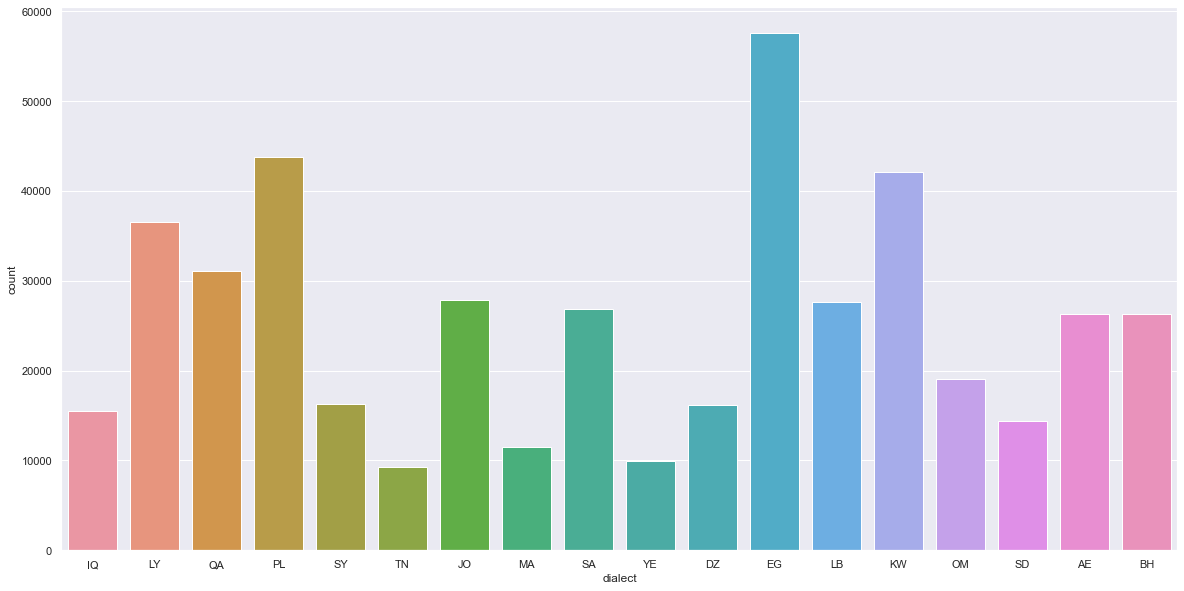

In [252]:
# distribution of the classes
sns_plot = sns.countplot(dataset["dialect"])
fig = sns_plot.get_figure()
fig.savefig(r"figures/dialect_distribution.png")

In [195]:
# create a list of the most frequent words in each dialect
most_freq_words = dict()
for dialect in dataset["dialect"].unique():
    most_freq_words[dialect] = (dict(dataset[dataset["dialect"] == dialect]['cleaned_tweet'].str.split(expand=True).stack().value_counts()[:50]))

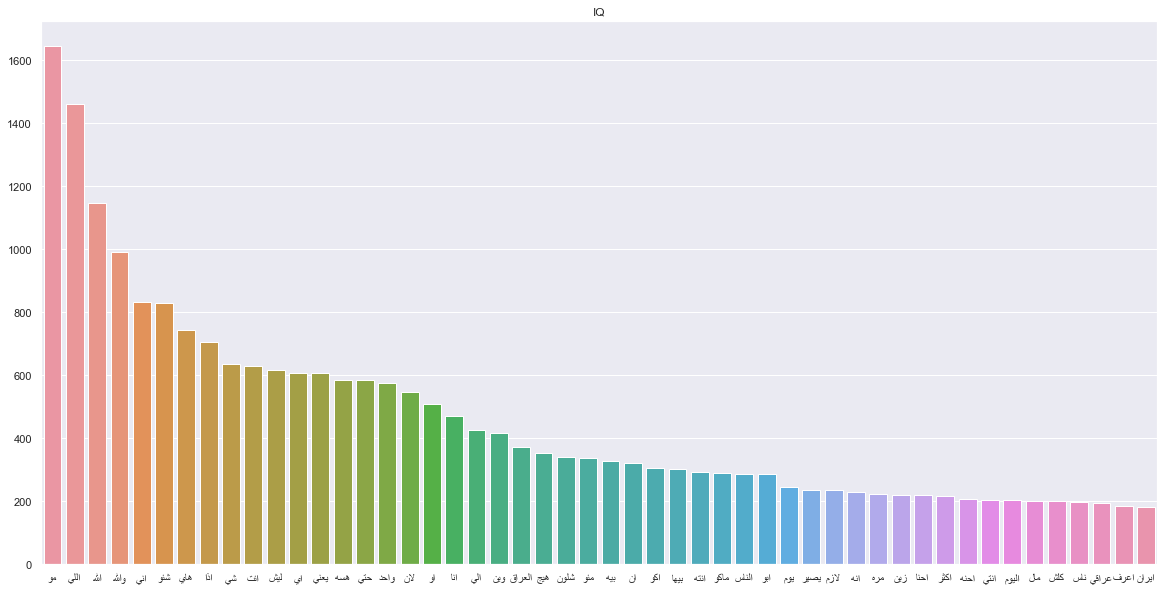

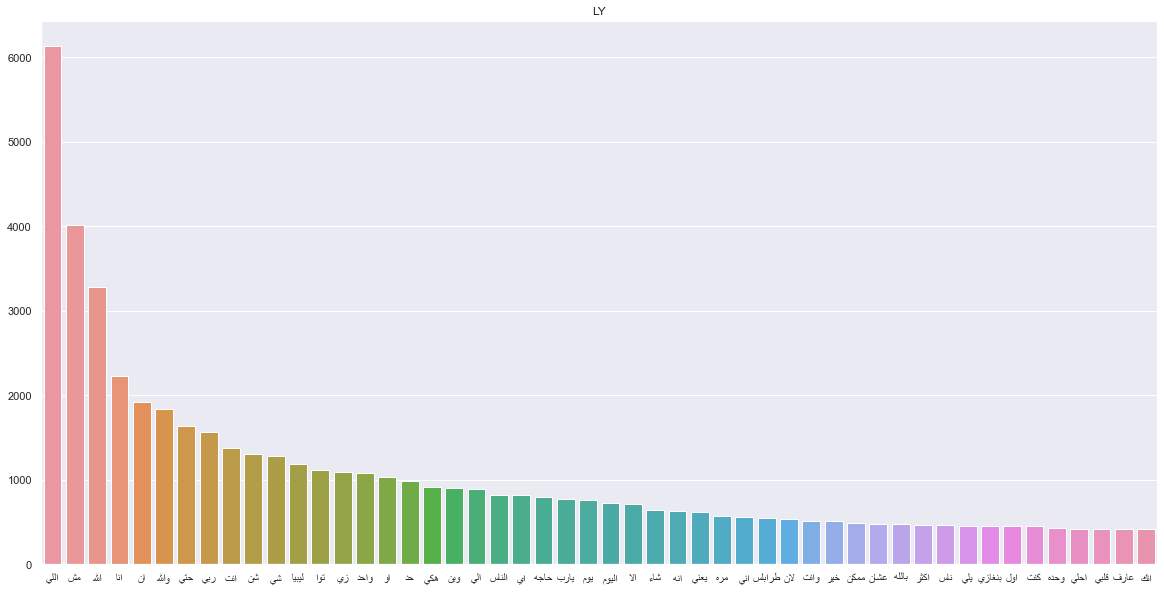

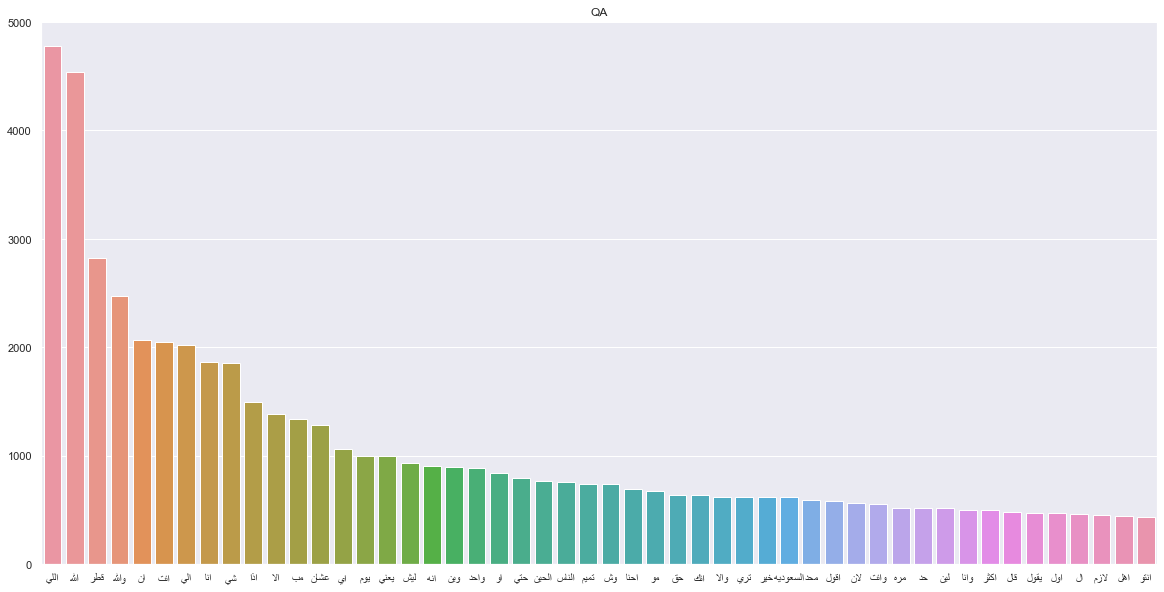

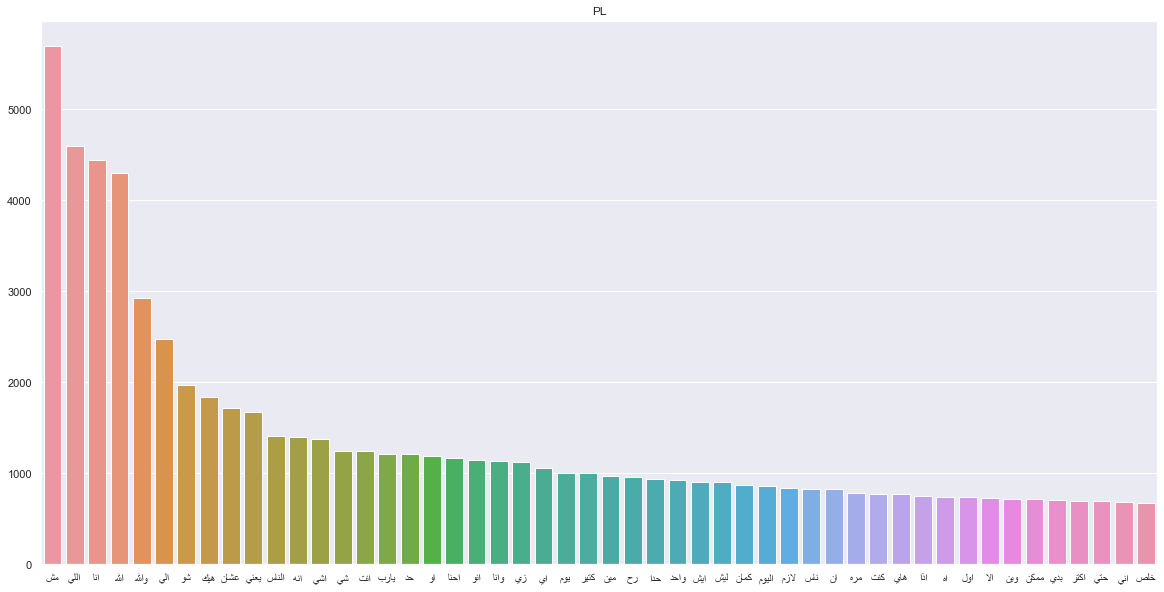

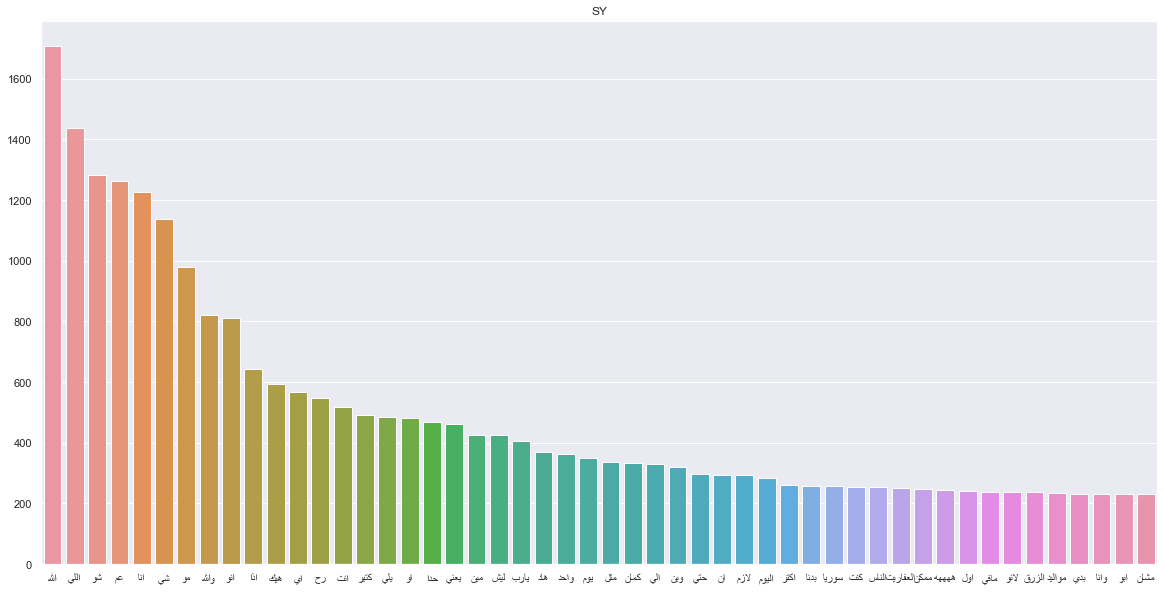

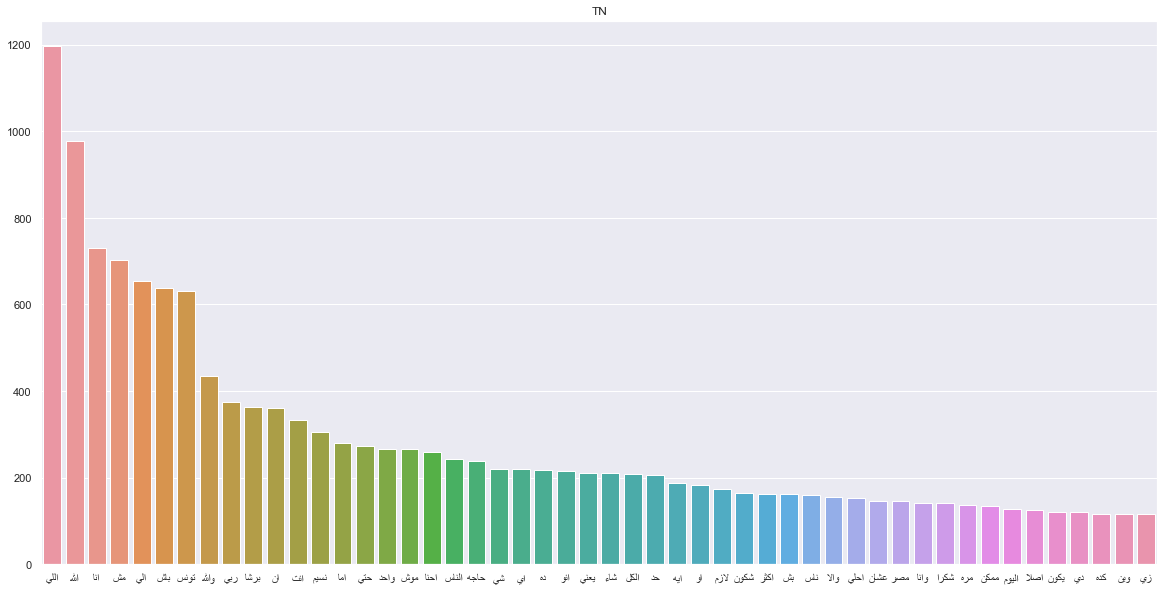

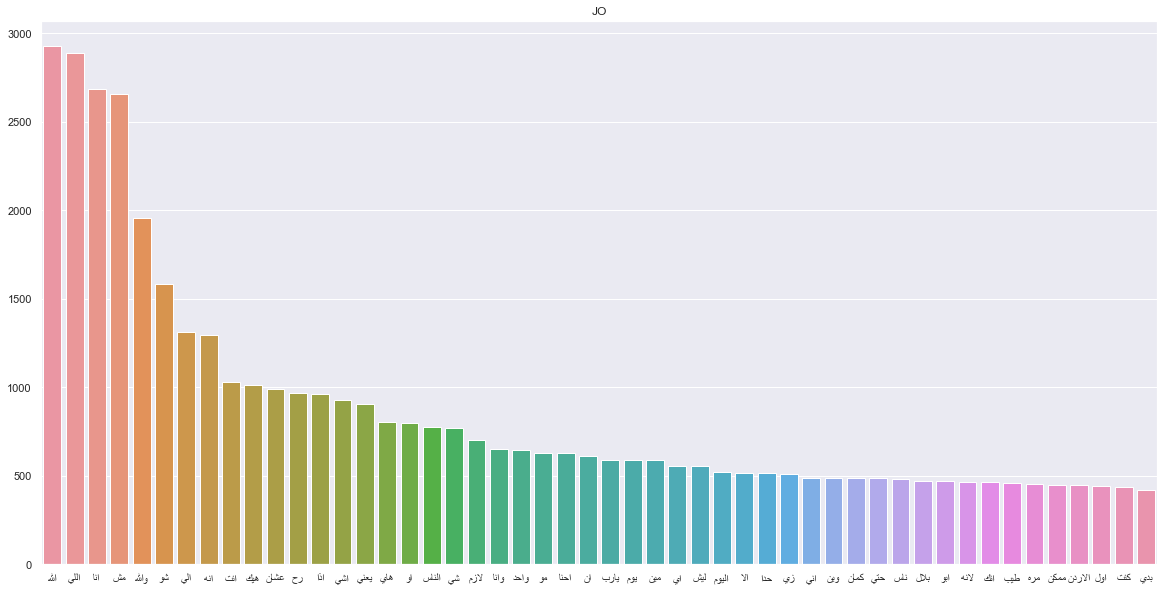

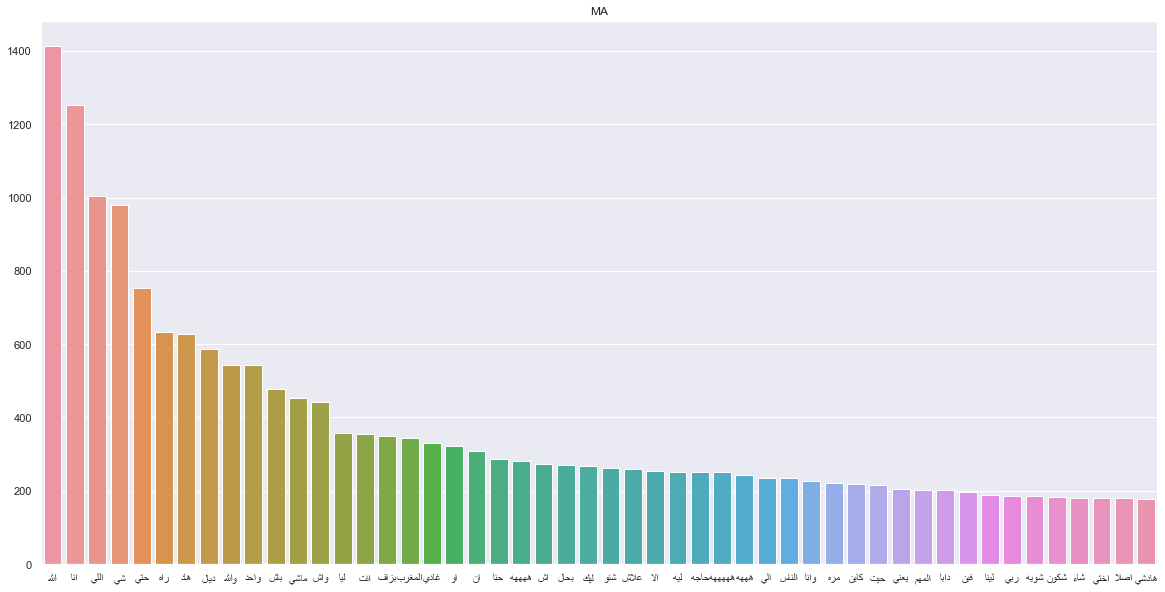

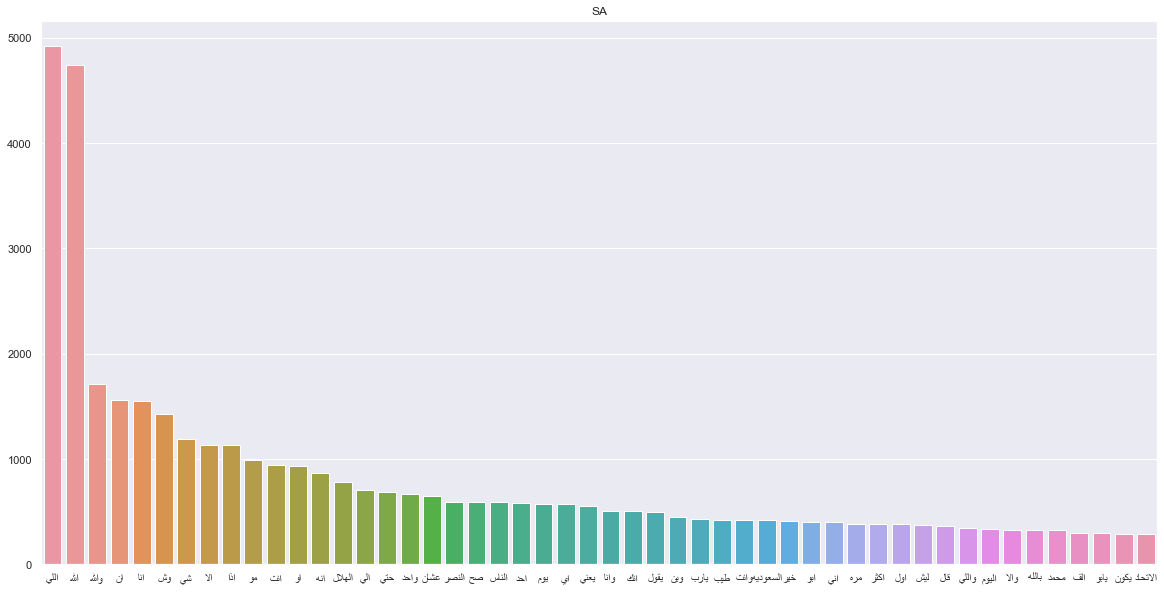

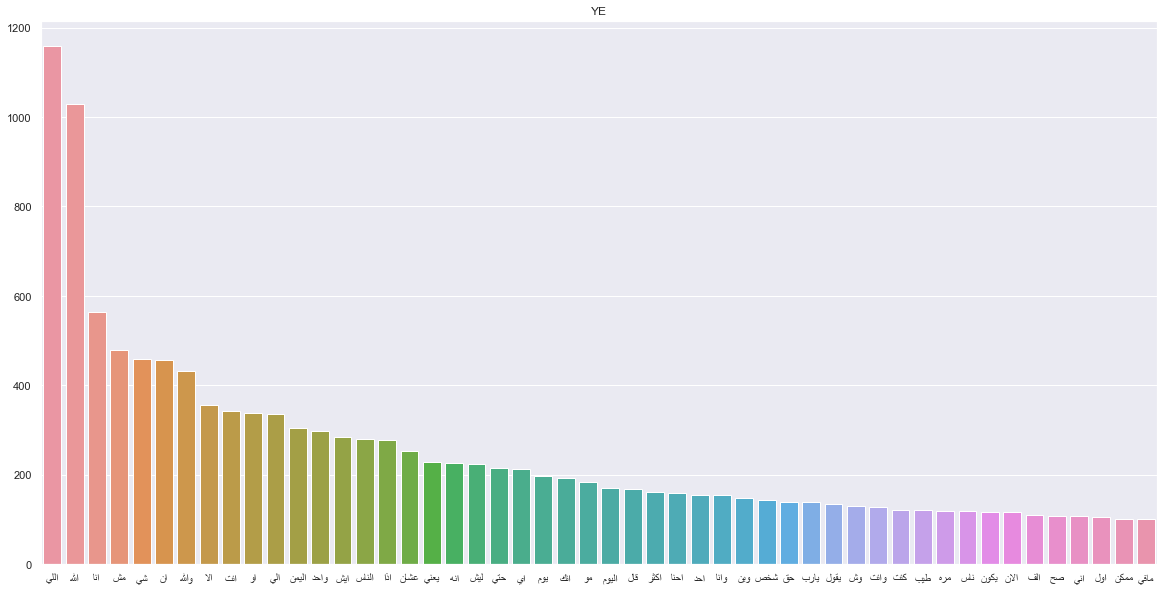

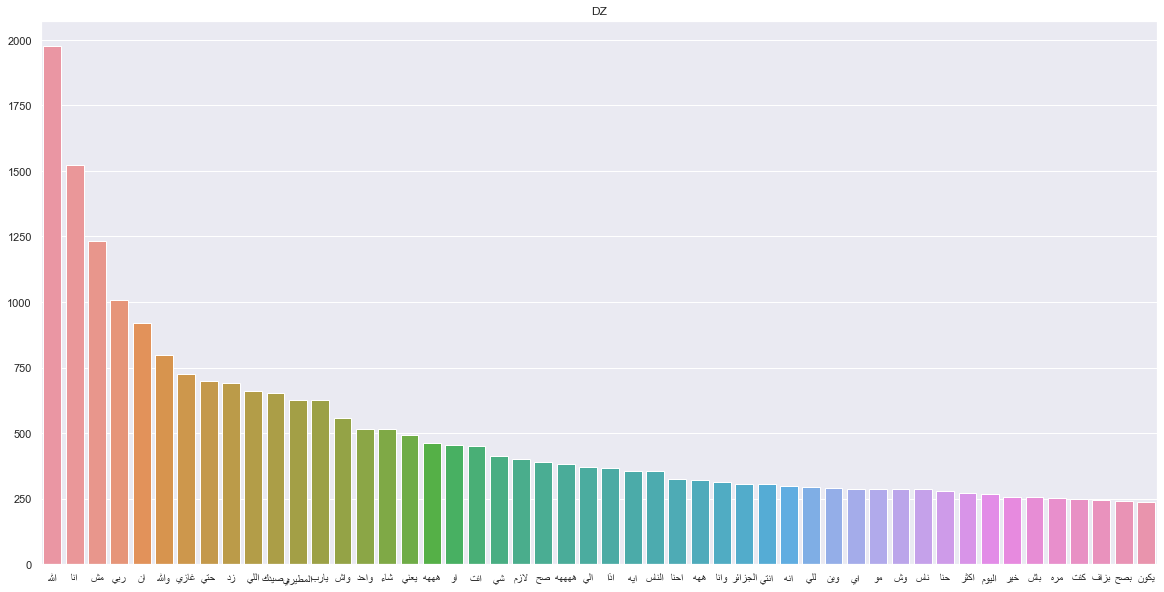

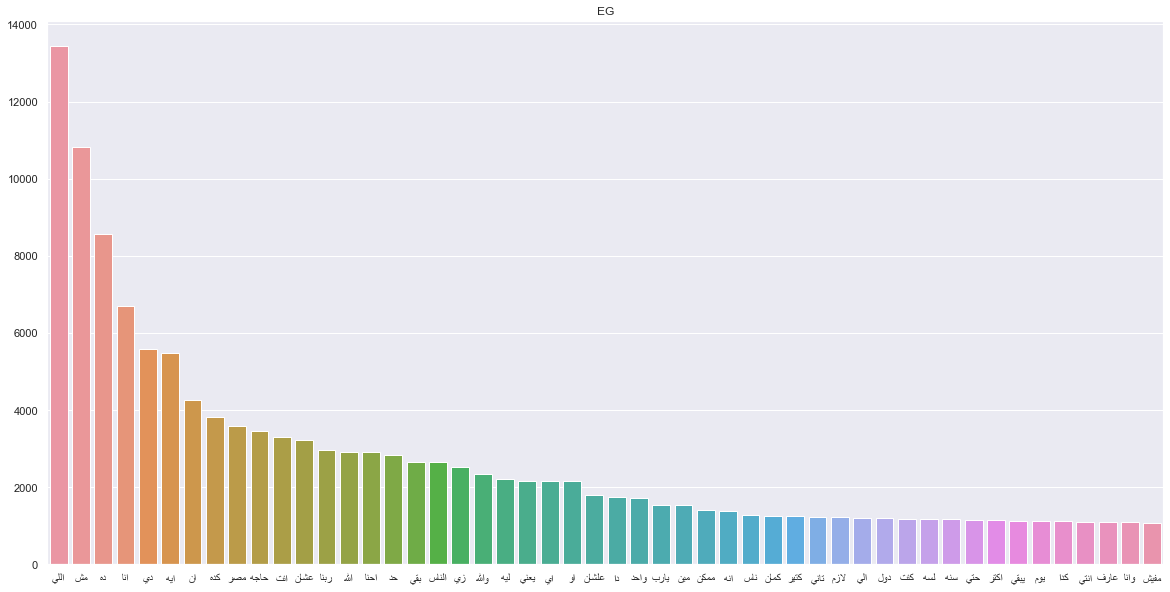

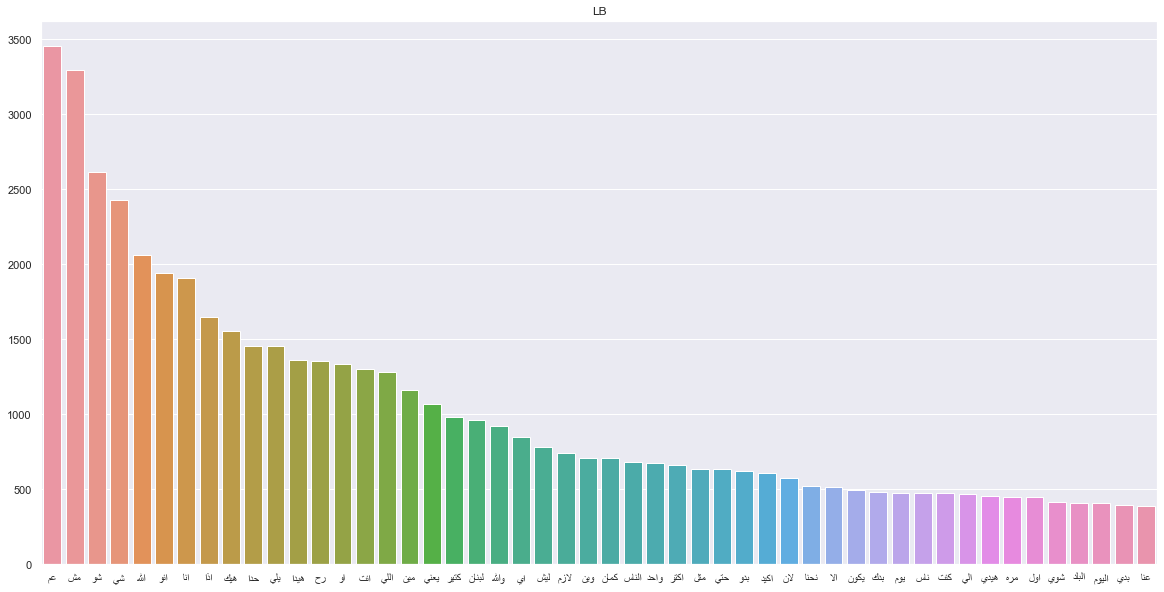

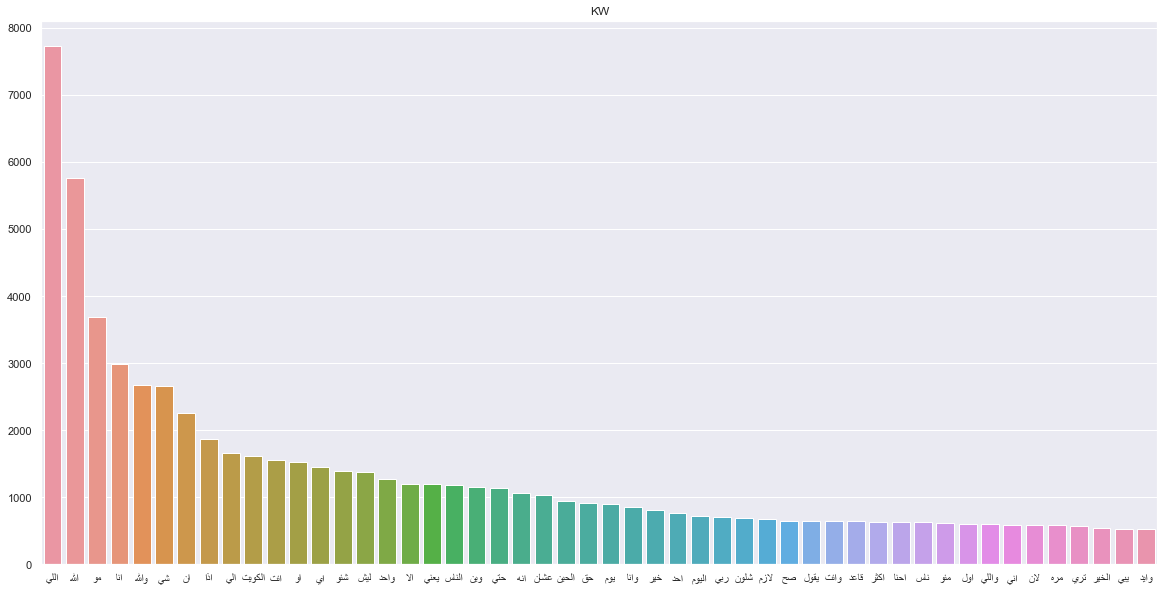

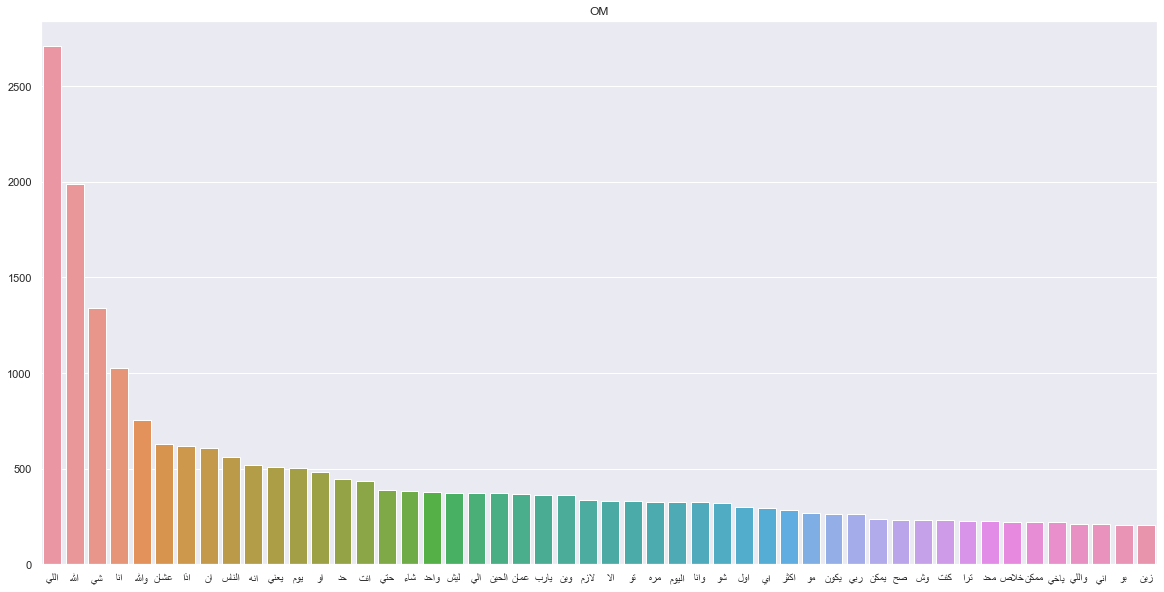

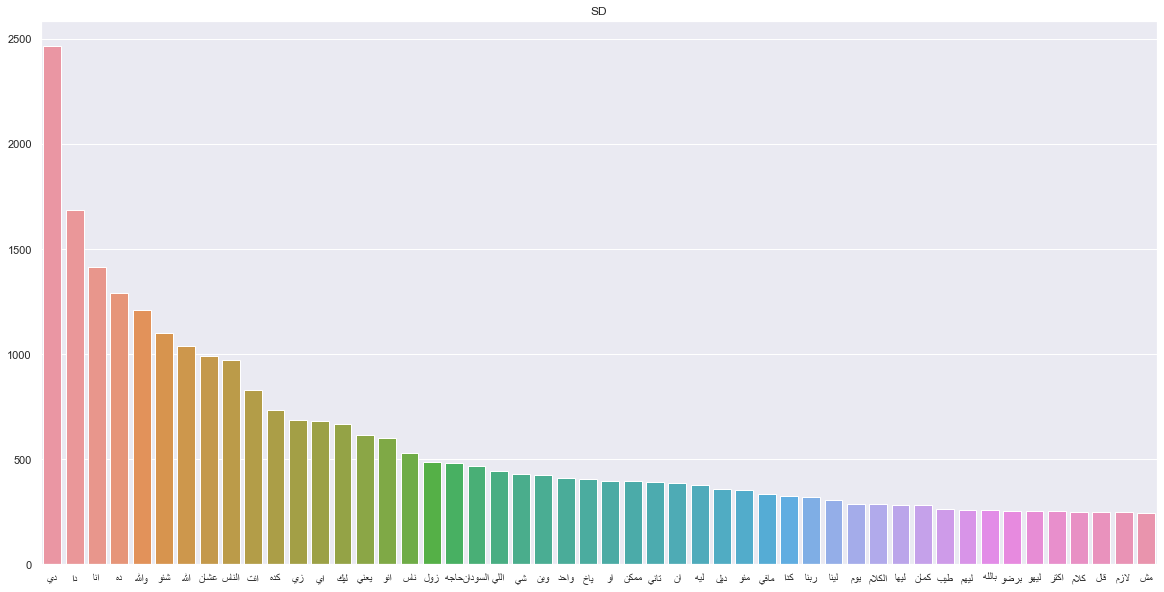

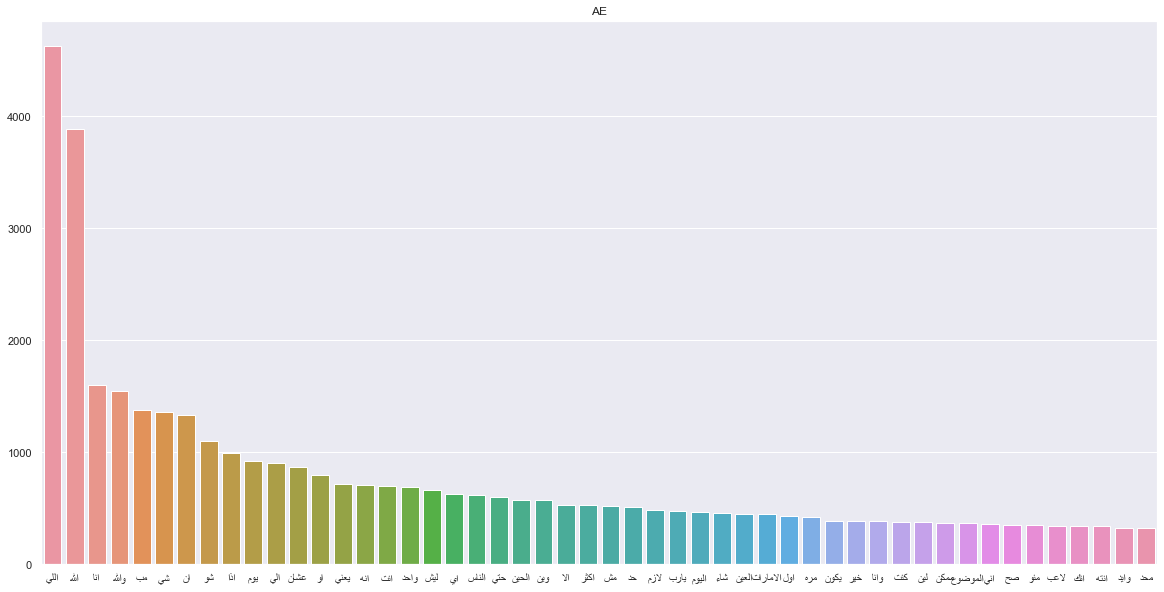

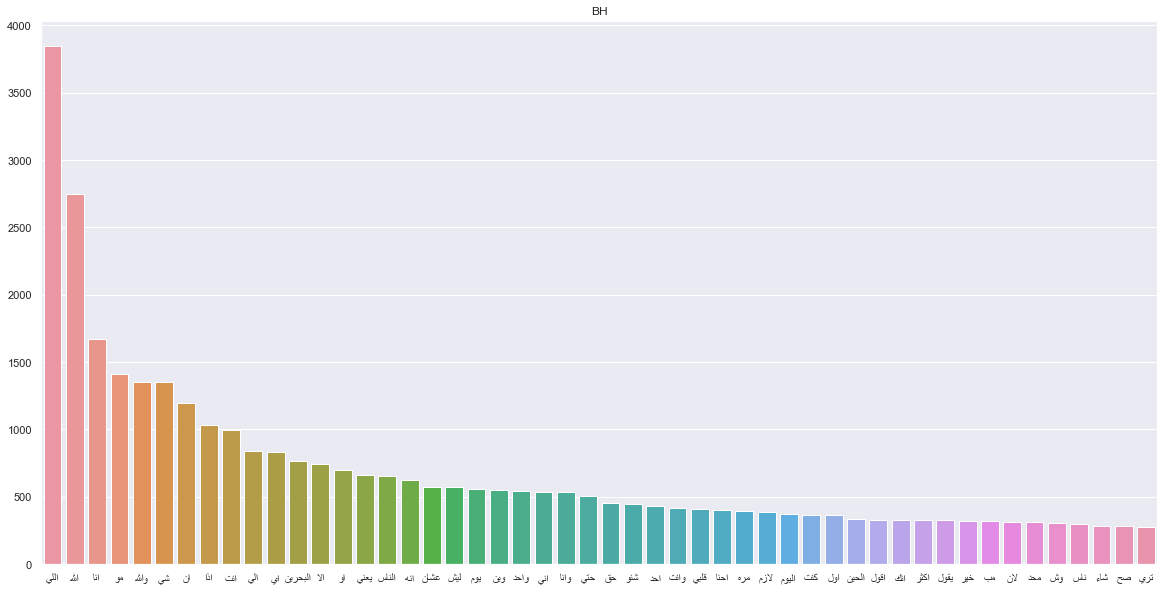

In [267]:
# visualize the most frequent words in each dialect
for j, dialect in enumerate(dataset["dialect"].unique()):
    fig, ax = plt.subplots(ncols=1, figsize=(20, 10))
    x = most_freq_words[dialect].keys()
    arabic = [get_display(arabic_reshaper.reshape(i)) for i in x]
    sns_plot = sns.barplot(x = arabic, y = list(most_freq_words[dialect].values()), ax = ax)
    ax.set_title(dialect) 
    fig = sns_plot.get_figure()
    fig.savefig(r"figures/{}_most_frequent_words.png".format(dialect))

# Save cleaned data to csv

In [283]:
dataset.to_csv('cleaned_tweets.csv', index=False)